# Recommendation system for restaurants
### Based on the [Yelp Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset).  

## 1. Data cleaning
### Based on [Ashish Gandhe's kernel](https://www.kaggle.com/wenqihou828/recommendation-for-yelp-users-itself).

In [ ]:
# Add preprocessing code here

## 2. Fake Review Detection
### Based on Zhiwei Zhang's [work](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781) and [code](https://github.com/zzhang83/Yelp_Sentiment_Analysis).

First of all, we define all the libraries we need.

In [16]:
from matplotlib.ticker import PercentFormatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import joblib as jl
import pickle

Then, in order to filter out deceptive reviews, that could alter the results
of our analysis, we load the model based on Support Vector Machine
defined in ```Yelp_sentiment_analysis/Scripts/fake_reviews.ipynb```
by [Zhiwei Zhang](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781),
that has the best scores for accuracy, precision, recall and f1-score.

In [2]:
vectorizer = jl.load('../models/tfidf_vectorizer.joblib')
svc = jl.load('../models/fake_review_svc_model.joblib')

Now, we can apply this model to our data.

In [3]:
# only for dev phase
frames_review = []
for chunk in pd.read_json('../dataset/yelp_academic_dataset_review.json', lines=True, chunksize = 20000):
    frames_review.append(chunk)
review = pd.concat(frames_review)

# final version
# pickle_review = open("vegas_review.pickle","rb")
# review = pickle.load(pickle_review)

review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [4]:
texts = list(review["text"])
X = vectorizer.transform(texts)
predictions = svc.predict(X)

In [5]:
print(type(predictions))
print(predictions)

<class 'numpy.ndarray'>
[ 1  1 -1 ...  1  1  1]


In [7]:
checked_review = review.assign(truth_score=predictions)

Let's see what we just obtained.

In [13]:
checked_review[['review_id', 'text', 'truth_score']].head()

,review_id,text,truth_score
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,1
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,-1
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,1
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1


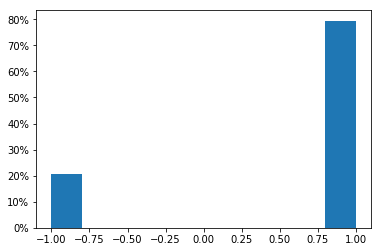

In [17]:
data = checked_review['truth_score']
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Finally, we can save the new dataset without the ```text``` column,
in order to save space and computation time.  

In [ ]:
checked_review.drop(columns=['text'])
checked_review.to_pickle('../dataset/checked_review.pickle')